In [ ]:
# Import necessary libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download NLTK stopwords and load them
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load training and test datasets
train=pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")
test=pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv")
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
train.shape

(159571, 8)

In [5]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


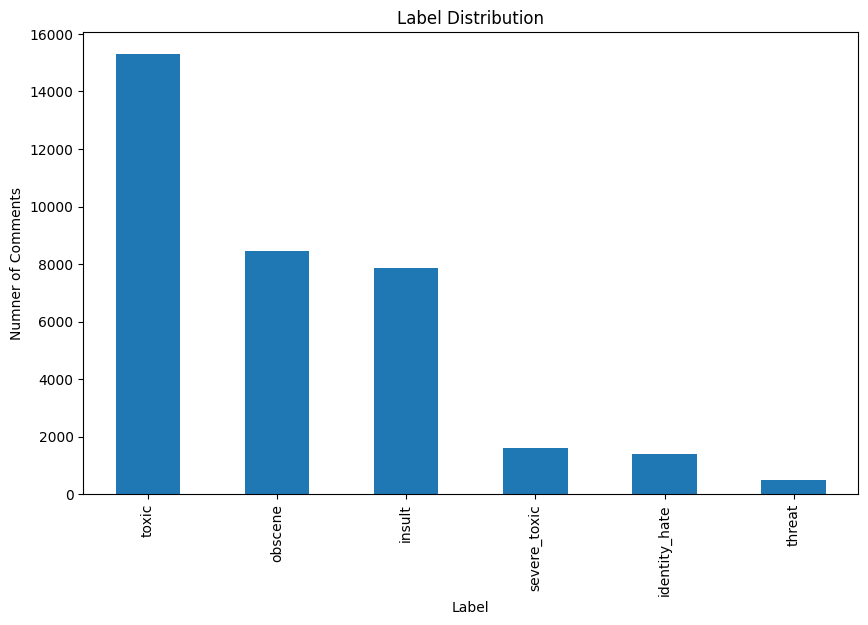

In [6]:
label_cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print(train[label_cols].sum())

plt.figure(figsize=(10,6))
train[label_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Numner of Comments")
plt.show()

In [7]:
MAX_NUM_WORDS = 100000
MAX_SEQUENCE_LENGTH = 200
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 100
GLOVE_DIR = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"

In [8]:
comment_train=train["comment_text"]
comment_test=test["comment_text"]

In [9]:
comment_train=list(comment_train)

In [ ]:
#Clean text data
def clean_text(text, remove_stopwords=True):
    text = str(text).replace('\n', '')

    text = re.sub(r'[^\w\s]','',text).lower()

    #remove stopwords
    if remove_stopwords:
        text = text.split()
        text = ' '.join(word for word in text if word not in stop_words)
        
    return str(text.strip()).replace("  ", " ")

In [11]:
texts = []
for line in tqdm_notebook(comment_train, total=len(comment_train)):
    texts.append(clean_text(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
#tokenize the text data
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

In [ ]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print("Vocabulary Size:", len(word_index))

Vocabulary Size: 305375


In [ ]:
#pad sequence
data = pad_sequences(sequences, padding="post", maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of Data Tensor:", data.shape)

y=train[label_cols].values
print("Shape of Label Tensor:", y.shape)

Shape of Data Tensor: (159571, 200)
Shape of Label Tensor: (159571, 6)


In [15]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
label = y[indices]

In [ ]:
#split data into training and validation sets
num_validation_sample = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_sample]
y_train = label[: -num_validation_sample]
x_val = data[-num_validation_sample:]
y_val = label[-num_validation_sample:]

In [17]:
print("Training", y_train.sum(axis=0))
print("Validation", y_val.sum(axis=0))

Training [12316  1274  6801   386  6353  1130]
Validation [2978  321 1648   92 1524  275]


In [18]:
print('Tokenized Sentences:', data[10])
print("One_Hot_Labes:", label[10])

Tokenized Sentences: [   14 58129   172   848  8103   841  4830   217     9   109    39  2391
 25946   514     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0

In [ ]:
#embedding with GloVe
embedding_index = {}

with open(GLOVE_DIR, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.asarray(values[1:], dtype='float32')

print("Proceding with Embedded Matrix", end = '')
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("\nCompleted")
    

Proceding with Embedded Matrix
Completed


In [ ]:
#focal loss function to handle class imbalance
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-9, 1. -1e-9)
        loss = -y_true * alpha * K.pow(1-y_pred, gamma) * K.log(y_pred)\
                -(1-y_true) * (1-alpha) * K.pow(y_pred, gamma) * K.log(1-y_pred)
        return K.mean(loss)
    return focal_loss_fixed

In [ ]:
#sample weights to handle class imbalance
max_weight=10
smoothing_factor=0.1
scaling_exponent=1.5

sample_weights = np.ones(len(y_train))

for i, col in enumerate(label_cols):
    neg, pos = np.bincount(y_train[:, i])
    total = neg + pos

    pos_weight = (neg/(pos+smoothing_factor))
    pos_weight=min(pos_weight, max_weight)

    pos_weight = np.power(pos_weight, scaling_exponent)
    sample_weights[y_train[:,i]==1]*=pos_weight

sample_weights /= np.mean(sample_weights)

In [ ]:
#define the model architecture
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')

embedding_layers = Embedding(len(word_index)+1, EMBEDDING_DIM, 
                             weights = [embedding_matrix], 
                             trainable = True,
                             name = 'embeddings')(sequence_input)

In [ ]:
#CNN layers
conv_blocks = []
for kernel_size in [3, 4, 5]:
    conv = Conv1D(128, kernel_size, activation='relu', padding='same', kernel_regularizer=l2(0.01))(embedding_layers)
    pool = GlobalMaxPooling1D()(conv)
    conv_blocks.append(pool)

x = Concatenate()(conv_blocks)

x = Reshape((-1, 128))(x)

#LSTM layers
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation = 'relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

preds = Dense(6, activation = 'sigmoid')(x)

In [30]:
model = Model(sequence_input, preds)
model.compile(loss = focal_loss(gamma=2., alpha=0.25),
              optimizer = Adam(learning_rate=0.0001),
              metrics = ['accuracy', AUC()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embeddings (Embedding)    │ (None, 200, 100)       │     30,537,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 200, 128)       │         38,528 │ embeddings[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 200, 128)       │         51,328 │ embeddings[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 200, 128)       │         64,128 │ embeddings[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 128)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 128)            │              0 │ conv1d_5[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 384)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 3, 128)         │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 3, 128)         │         98,816 │ reshape_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         41,216 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          8,320 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 30,849,350 (117.68 MB)

 Trainable params: 30,848,966 (117.68 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = 32, 
                    validation_data = (x_val, y_val),
                    sample_weight=sample_weights,
                    callbacks= [
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]
)

Epoch 1/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 138s 31ms/step - accuracy: 0.1714 - auc_1: 0.5218 - loss: 4.2037 - val_accuracy: 0.2565 - val_auc_1: 0.6682 - val_loss: 2.3089 - learning_rate: 1.0000e-04
Epoch 2/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.1811 - auc_1: 0.5797 - loss: 2.0826 - val_accuracy: 0.2760 - val_auc_1: 0.7499 - val_loss: 0.8533 - learning_rate: 1.0000e-04
Epoch 3/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.1997 - auc_1: 0.6479 - loss: 0.7531 - val_accuracy: 0.1646 - val_auc_1: 0.7876 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 4/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.2294 - auc_1: 0.6842 - loss: 0.3588 - val_accuracy: 0.6569 - val_auc_1: 0.8449 - val_loss: 0.1808 - learning_rate: 1.0000e-04
Epoch 5/10
3990/3990 ━━━━━━━━━━━━━━━━━━━━ 123s 31ms/step - accuracy: 0.3921 - auc_1: 0.7619 - loss: 0.1553 - val_accuracy: 0.9914 - val_auc_1: 0.8887 - val_loss: 0.0725 - learning_rate: 1.0000e-04
Epoch 6/10
3990

In [ ]:
#predicting on test data
test = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv")
test = test.merge(test_labels, on="id")

test_sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
y_test = test[label_cols].values

y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = np.mean((y_test_pred_binary == y_test).all(axis=1))
print(f"Exact Match Accuracy: {test_accuracy:.4f}")

per_class_accuracy = (y_test_pred_binary == y_test).mean(axis=0)
for label, acc in zip(label_cols, per_class_accuracy):
    print(f"{label} Accuracy: {acc:.4f}")

print("\nConfusion Matrices:")
for i, label in enumerate(label_cols):
    tn = np.sum((y_test[:, i] == 0) & (y_test_pred_binary[:, i] == 0))
    fp = np.sum((y_test[:, i] == 0) & (y_test_pred_binary[:, i] == 1))
    fn = np.sum((y_test[:, i] == 1) & (y_test_pred_binary[:, i] == 0))
    tp = np.sum((y_test[:, i] == 1) & (y_test_pred_binary[:, i] == 1))
    
    print(f"\n{label}:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step
Exact Match Accuracy: 0.3769
toxic Accuracy: 0.3853
severe_toxic Accuracy: 0.4150
obscene Accuracy: 0.3987
threat Accuracy: 0.4163
insult Accuracy: 0.3984
identity_hate Accuracy: 0.4130

Confusion Matrices:

toxic:
True Negatives: 57368
False Positives: 520
False Negatives: 4450
True Positives: 1640

severe_toxic:
True Negatives: 63500
False Positives: 111
False Negatives: 302
True Positives: 65

obscene:
True Negatives: 60009
False Positives: 278
False Negatives: 2640
True Positives: 1051

threat:
True Negatives: 63761
False Positives: 6
False Negatives: 211
True Positives: 0

insult:
True Negatives: 60214
False Positives: 337
False Negatives: 2626
True Positives: 801

identity_hate:
True Negatives: 63243
False Positives: 23
False Negatives: 696
True Positives: 16


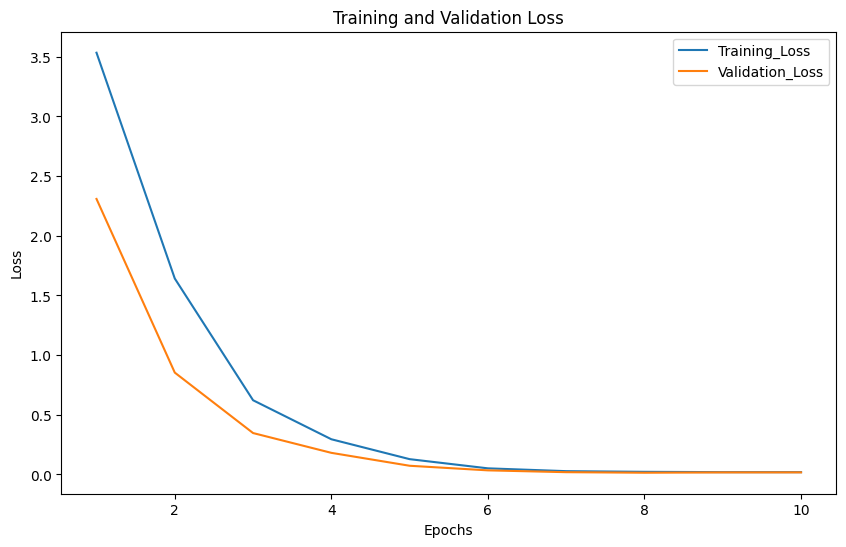

In [ ]:
#plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,6))
sns.lineplot(x=epochs, y=loss, label = 'Training_Loss')
sns.lineplot(x=epochs, y=val_loss, label = 'Validation_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

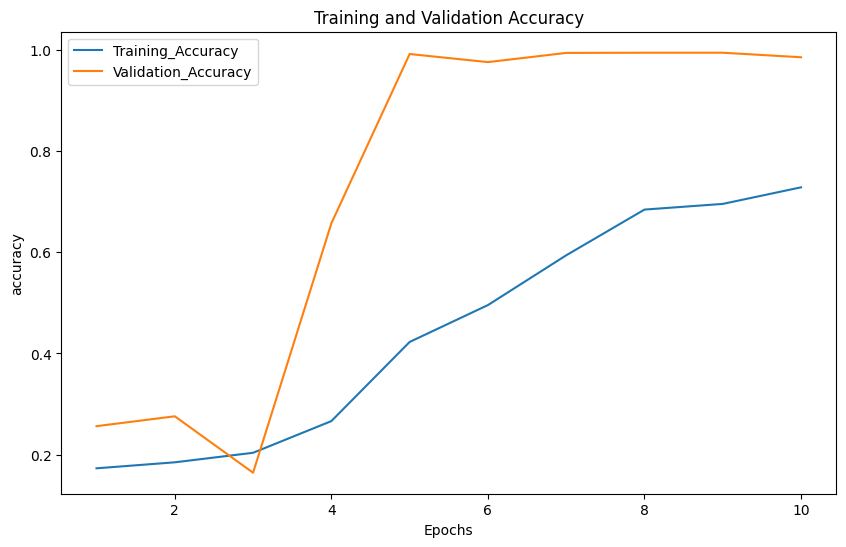

In [ ]:
##plot training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(accuracy)+1)

plt.figure(figsize=(10,6))
sns.lineplot(x=epochs, y=accuracy, label = 'Training_Accuracy')
sns.lineplot(x=epochs, y=val_accuracy, label = 'Validation_Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
#function to predict toxicity levels for a given comment
def predict_toxicity(comment):
    comment = clean_text(comment)
    sequence = tokenizer.texts_to_sequences([comment])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    predictions = model.predict(padded_sequence)[0]
    threshold = 0.2
    detected_labels = [label_cols[i] for i, score in enumerate(predictions) if score>threshold]

    toxic_scores = dict(zip(label_cols, predictions.tolist()))

    if not detected_labels:
        average_toxic_score = np.mean(predictions)
        non_toxic_score = 1-average_toxic_score
        toxic_scores['Non-toxic'] = non_toxic_score

    return toxic_scores
    
while True:
    user_input = input("\nEnter a comment (or type 'exit' to quit): ")
    if user_input.lower() == "exit":
        print("Exiting...")
        break

    prediction_result = predict_toxicity(user_input)
    print("Prediction Toxicity Levels:", prediction_result)


Enter a comment (or type 'exit' to quit):  I think its crap that the link to roggenbier is to this article. Somebody that knows how to do things should change it.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Toxicity Levels: {'toxic': 0.18034876883029938, 'severe_toxic': 0.10284800082445145, 'obscene': 0.1341886818408966, 'threat': 0.10048811882734299, 'insult': 0.14372356235980988, 'identity_hate': 0.10685799270868301, 'Non-toxic': 0.8719241470098495}



Enter a comment (or type 'exit' to quit):  Asshole, your dirty MF people tries to steal our glory and heavy persian (tajik) history by claiming us Awghans (mother/donkeyfuckers)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Toxicity Levels: {'toxic': 0.5227188467979431, 'severe_toxic': 0.2549087703227997, 'obscene': 0.4330967664718628, 'threat': 0.20414608716964722, 'insult': 0.41369298100471497, 'identity_hate': 0.24840767681598663}



Enter a comment (or type 'exit' to quit):  You are a gay homo. I hope you choke on your penis and die. I am sending a big bleck guy to jizz in your face.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction Toxicity Levels: {'toxic': 0.6618187427520752, 'severe_toxic': 0.3413165807723999, 'obscene': 0.5731756687164307, 'threat': 0.2523827850818634, 'insult': 0.5393520593643188, 'identity_hate': 0.31715548038482666}



Enter a comment (or type 'exit' to quit):  and i'm going to keep posting the stuff u deleted until this fucking site closes down have fun u stupid ass bitch don't ever delete anything fuckin hore like i said before go to hell


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction Toxicity Levels: {'toxic': 0.7454513907432556, 'severe_toxic': 0.4201875329017639, 'obscene': 0.6775214672088623, 'threat': 0.30028754472732544, 'insult': 0.6343549489974976, 'identity_hate': 0.3750919699668884}



Enter a comment (or type 'exit' to quit):  exit


Exiting...
